# TensorFlow・Kerasのトレーニング♨

## CNN - 画像の前処理 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [共通関数](#共通関数)
- [画像の前処理](#画像の前処理)
  - [画像の取得](#画像の取得)
  - [様々な変換処理](#様々な変換処理)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python - DL  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python%20-%20DL

## [環境準備](TensorFlowAndKeras0.ipynb)

### インポート

In [1]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
print(tf.__version__)

import keras
print(keras.__version__)
# モデル定義
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Dense, Input, Activation, Flatten, Dropout, LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import SGD, Adam
# その他
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from keras.utils import np_utils

import cv2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2.11.0
2.11.0


### 共通関数

#### 画像比較

In [2]:
def diff_image_info(img1, img2, cmap1=None, cmap2=None):
    print(img1.shape)
    print(img2.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap2)

#### 画像回転

In [3]:
def opencv_rotate(img, angle=30):
    size = (img.shape[0], img.shape[1])
    center = (int(size[0]/2), int(size[1]/2))
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, rotation_matrix, size)

#### 画像並進

In [4]:
def opencv_move(img, h=100, v=50):
    rows, cols, channnels = img.shape
    M = np.float32([[1,0,h],[0,1,v]])
    return cv2.warpAffine(img, M, (cols, rows))

#### 画像拡大

In [5]:
def opencv_zoomin(img, h=2.0, v=2.0):
    zoomed = cv2.resize(img, None, fx=h, fy=v)
    height_1, width_1, channel_1 = img.shape
    height_2, width_2, channel_2 = zoomed.shape
    x =  int((width_2 - width_1) / 2)
    y =  int((height_2 - height_1) / 2)
    return zoomed[y:y+height_1, x:x+width_1]

#### ヒストグラム平坦化

In [6]:
def opencv_clahe(img, clipLimit=2.0, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

#### Mean Subtraction

In [7]:
def img_meansubtraction(img):
    img2 = img.astype('f')
    
    # スケーリング処理
    img2 /= 255 # 0～1正規化
    img2 -= np.mean(img2) # Mean Subtraction
    return img2

#### 画像のピクセル値の正規化

In [8]:
def img_min_max(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

#### ガンマ変換

In [9]:
def opencv_gamma(img, gamma=0.5):
    look_up_table = np.zeros((256, 1), dtype='uint8')
    for i in range(256):
        look_up_table[i][0] = 255 * pow(float(i) / 255, 1.0 / gamma)
    return cv2.LUT(img, look_up_table)

#### ガウシアンノイズ

In [10]:
def img_gaussian_noise(img, loc=0.0, scale=5.0):
    row, col, ch = img.shape
    noise = np.random.normal(loc, scale, (row, col, ch))
    noise = noise.reshape(row, col, ch)
    noised = img + noise
    noised /= 255
    return noised

#### その他、ワンライナー系

In [11]:
# リサイズ
def opencv_resize(img, h, w):
    return cv2.resize(img, (h, w))

# クロップ
def img_cropping(img, h, w):
    return img[h[0]:h[1], w[0]:w[1], :]

# クロップ（％
def img_cropping_p(img, hp, wp):
    h, w, c = img.shape
    return img[int(h * hp[0]): int(h * hp[1]):, int(w * wp[0]): int(w * wp[1]), :]

# bgr -> rgb
def opencv_bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# グレースケール化
def opencv_rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 2値化
def opencv_binary(img, threshold=125):
    # 二値化(閾値を超えた画素を255にする。)
    return cv2.threshold(grayed, threshold=125, 255, cv2.THRESH_BINARY)

# 左右反転
def opencv_flip_horizontal(img):
    return cv2.flip(img, 1)

# 上下反転
def opencv_flip_vertical(img):
    return cv2.flip(img, 0)

# 平滑化
def opencv_gaussian_blur(img, ksize=(10, 10), sigma=0):
    return cv2.GaussianBlur(img, ksize, sigma)

## 画像の前処理

### 画像の取得

#### ダウンロード
プロキシの書き方がよく判らんので環境変数で。

In [12]:
import urllib
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=Lenna.png&refer=FrontPage'
data = urllib.request.urlopen(url).read()
with open("lenna.png", mode="wb") as f:
    f.write(data)

#### 読込・確認

<class 'numpy.ndarray'>
(512, 512, 3)


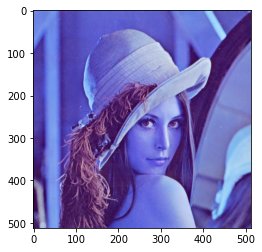

In [13]:
img = cv2.imread('lenna.png')
print(type(img))
print(img.shape)

# 既定の色空間がBGRなので青みがかる。
plt.imshow(img)

#### 変換して保存

True

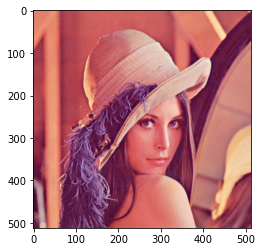

In [14]:
# 色空間をRGBに変更。
img = opencv_bgr2rgb(img)
# 元のRGB解釈の色合いで表示される。
plt.imshow(img)
# RGB解釈で保存
cv2.imwrite('new_lenna.jpg', img)

### 様々な変換処理

#### リサイズ
学習に画像データを入力するときは画像のサイズを揃える。

(512, 512, 3)
(224, 224, 3)


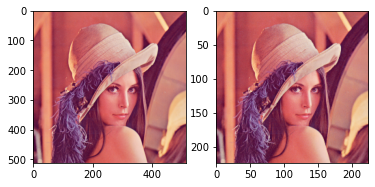

In [15]:
img2 = opencv_resize(img, 224, 224)
diff_image_info(img, img2)

#### クロップ
画像の一部を切り抜く処理はarrayのスライシングで実装。

##### ピクセル

(512, 512, 3)
(300, 300, 3)


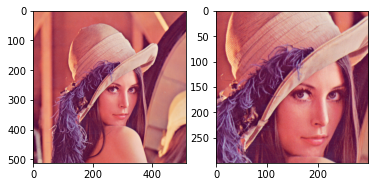

In [16]:
img2 = img_cropping(img, [100, 400], [100, 400])
diff_image_info(img, img2)

##### 比率

(512, 512, 3)
(307, 307, 3)


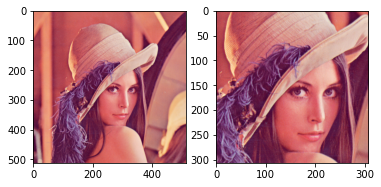

In [17]:
img2 = img_cropping_p(img, [(1/5), (4/5)], [(1/5), (4/5)])
diff_image_info(img, img2)

#### 明るさ調整

##### グレースケール化
色の意味合いが低い場合、モノクロ画像に変換し計算量を減らす。

(512, 512, 3)
(512, 512)


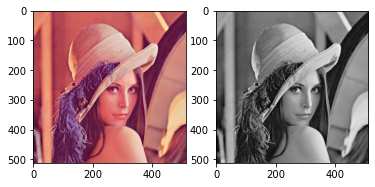

In [18]:
grayed = opencv_rgb2gray(img)
diff_image_info(img, grayed, cmap2='gray')

##### 2値化
- グレーを使わない白と黒の2色に変換。
- スクリーン・トーンと同様の表現で、更に計算量を減らす。

(512, 512)
(512, 512)


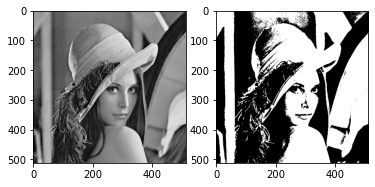

In [19]:
th, binary = opencv_binary(img)
diff_image_info(grayed, binary, cmap1='gray', cmap2='gray')

##### 平滑化
画像をぼやかしノイズ（ガサつきなど）を取り除く。

(512, 512)
(512, 512)


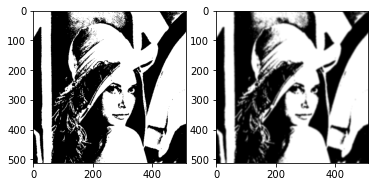

In [20]:
blurred = opencv_gaussian_blur(img)
diff_image_info(binary, blurred, cmap1='gray', cmap2='gray')

##### ヒストグラム平坦化
画像の明るさの範囲を引き伸ばすと明暗部分でも輪郭線が認識し易くなる。

(512, 512)
(512, 512)


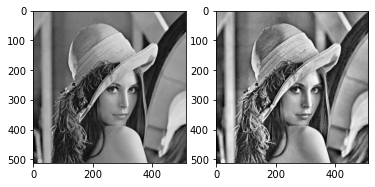

In [21]:
clahed = opencv_clahe(grayed)
diff_image_info(grayed, clahed, cmap1='gray', cmap2='gray')

##### Mean Subtraction
- 0 ～ 1正規化と合わせた標準化のようなスケーリング処理
- BatchNormalizationのように共変量シフトを抑制できる｡

※ img単位ではなくxに対して適用できる。

(512, 512)
(512, 512)


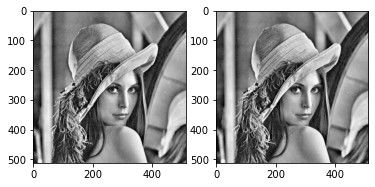

In [22]:
img2 = img_meansubtraction(clahed)
diff_image_info(clahed, img2, cmap1='gray', cmap2='gray')

##### 画像のピクセル値の正規化
※ img単位ではなくxに対して適用できる。

(512, 512)
(512, 512)


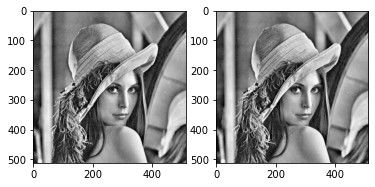

In [23]:
img3 = img_min_max(clahed)
diff_image_info(clahed, img3, cmap1='gray', cmap2='gray')

#### データ拡張（data augmentation）
データ拡張は過学習を防ぐ方法の一つ。

##### 左右反転

(512, 512, 3)
(512, 512, 3)


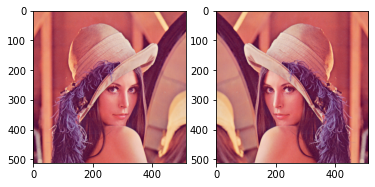

In [24]:
flipped = opencv_flip_horizontal(img)
diff_image_info(img, flipped)

##### 上下反転
学習データとして成立する場合  
（回転するモノや上や下から見た場合など

(512, 512, 3)
(512, 512, 3)


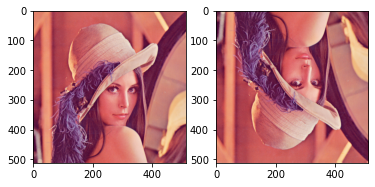

In [25]:
flipped = opencv_flip_vertical(img)
diff_image_info(img, flipped)

##### 回転実行

(512, 512, 3)
(512, 512, 3)


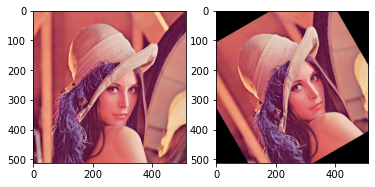

In [26]:
rotated = opencv_rotate(img, 30)
diff_image_info(img, rotated)

##### 並進実行

(512, 512, 3)
(512, 512, 3)


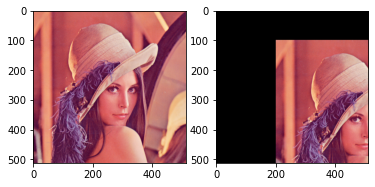

In [27]:
moved = opencv_move(img, 200, 100)
diff_image_info(img, moved)

##### 拡大実行

(512, 512, 3)
(512, 512, 3)


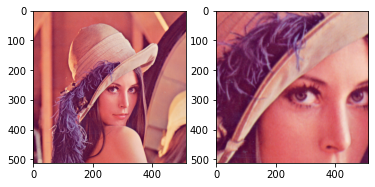

In [28]:
zoomed = opencv_zoomin(img, 3, 3)
diff_image_info(img, zoomed)

##### ガンマ変換
画像の明るさを全体的に明るく or 暗くする処理

(512, 512, 3)
(512, 512, 3)


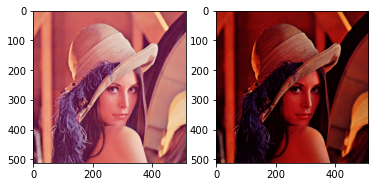

In [29]:
img_gamma = opencv_gamma(img, 0.3)
diff_image_info(img, img_gamma)

##### ガウシアンノイズ
画像の加工過程で発生する粒が散らばったようなノイズを加える。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
(512, 512, 3)


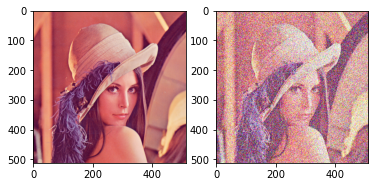

In [30]:
img_gn = img_gaussian_noise(img, 50, 100)
diff_image_info(img, img_gn)